<a href="https://colab.research.google.com/github/moka-co/twitter_emo_classification/blob/main/emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Emotion Classification

Emotion Classification is a multi-label text classification task

Dataset used for this tasks and information about where they came from can be found on this project Github Repository: clone https://github.com/moka-co/twitter_emo_classification.git

# Environment Setup

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import datasets
import pandas as pd
import random
import os
from collections import Counter
import re

# Data Acquisition

In [3]:
# Clone the repo
if not os.path.exists("twitter_emo_classification"):
  !git clone https://github.com/moka-co/twitter_emo_classification.git
  %cp twitter_emo_classification/data/* .

Cloning into 'twitter_emo_classification'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 25 (delta 8), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 19.02 MiB | 9.73 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [62]:
dataset = pd.read_pickle("merged_training.pkl")

In [5]:
# Get Glove embeddings
if not os.path.exists("glove.6B.zip"):
  print("🚀 Starting GloVe download...")
  !wget -q http://nlp.stanford.edu/data/glove.6B.zip
  !unzip glove.6B.zip > /dev/null 2>&1 &
  print("Finished GloVe download")


# Function that defines a glove embeddings matrix
def load_glove_embeddings(path, word2idx, embedding_dim=100):
    """
    path: path to glove.6B.100d.txt
    word2idx: dictionary mapping words to integers from your dataset
    """
    vocab_size = len(word2idx)
    # Initialize matrix with random values (or zeros)
    embedding_matrix = torch.randn(vocab_size, embedding_dim)

    with open(path, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = torch.tensor([float(x) for x in values[1:]])
                idx = word2idx[word]
                embedding_matrix[idx] = vector

    return embedding_matrix

🚀 Starting GloVe download...
Finished GloVe download


In [63]:
# Download nltk tokenizer
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [64]:
dataset2 = None

if not os.path.exists("SemEval2018-Task1-all-data.zip"):
  !wget -q https://saifmohammad.com/WebDocs/AIT-2018/AIT2018-DATA/SemEval2018-Task1-all-data.zip
  !unzip -q SemEval2018-Task1-all-data.zip
  !rm -r __MACOSX/

sem_eval_path_train = "/content/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-train.txt"
sem_eval_path_val = "/content/SemEval2018-Task1-all-data/English/E-c/2018-E-c-En-test-gold.txt"

dict_semeval_columns = ['tweet_id','text','anger', 'anticipation', 'disgust', 'fear', 'joy',
    'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust'
]

dataset2 = pd.read_csv(sem_eval_path_train,
        sep='\t',
        header=0,
        names=dict_semeval_columns
    )

In [65]:
dataset2.head()

,tweet_id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-En-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-En-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-En-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-En-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-En-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


I'm going to merge the two dataset together. As criteria, i'm selecting only the rows from the dataset 2 that are compatible with dataset 1 i.e rows labeled with 1 only if the label is present in the first set of labels.

First i want to check if there are any duplicates i.e text contained in both dataset

In [66]:
# Check duplicates
duplicates = [dataset2["text"].isin(dataset["text"])]
print(f"Duplicates: {len(duplicates)}")

Duplicates: 1


In [67]:
# Merge dataset2 with dataset 1
df = dataset
emotion_to_id = dict(enumerate(df['emotions'].astype('category').cat.categories))

# Filter rows
def filter_rows(target_df, emotion_mapping):
    """
    Returns rows where none of the specified emotions are present (all 0s).
    """
    # Extract the emotion names from your dictionary
    target_emotions = list(emotion_mapping.values())

    # Filter only the columns that actually exist in the dataframe to avoid KeyErrors
    existing_cols = [col for col in target_emotions if col in target_df.columns]

    # Sum the emotion columns value horizontally (axis=1) and keep rows where the sum is 0
    mask = target_df[existing_cols].sum(axis=1) == 0
    negative_df = target_df[mask].copy()

    print(f"✅ Filtered {len(negative_df)} rows out of {len(target_df)}")
    return negative_df

negative = filter_rows(dataset2, emotion_to_id) # Dataset containing only rows with label not present in dataset1

# take only compatible rows:
positive = dataset2[~dataset2.index.isin(negative.index)]

# Create semeval_subset directly from positive text
semeval_subset = pd.DataFrame({
    'text': positive['text'].values
}, index=positive.index)

# 2. Identify which columns in 'positive' map to our target emotions
alignment_map = {
'anger': 'anger',
'fear': 'fear',
'joy': 'joy',
'love': 'love',
'sadness': 'sadness',
'surprise': 'surprise',
'disgust': 'anger' # Common academic grouping: Disgust often maps to Anger
}

present_cols = [col for col in alignment_map.keys() if col in positive.columns]

semeval_subset['emotions'] = positive[present_cols].any(axis=1).astype(int)
def map_to_primary(row):
    for col in present_cols:
        if row[col] == 1:
            return alignment_map[col]


semeval_subset['emotions'] = positive.apply(map_to_primary, axis=1)

✅ Filtered 591 rows out of 6838


In [68]:
# Visualize that now it has the desired structure
semeval_subset.head()

,text,emotions
1,Whatever you decide to do make sure it makes y...,joy
2,@Max_Kellerman it also helps that the majorit...,anger
3,Accept the challenges so that you can literall...,joy
4,My roommate: it's okay that we can't spell bec...,anger
5,No but that's so cute. Atsu was probably shy a...,joy


In [69]:
df.head()

,text,emotions
27383,i feel awful about it too because it s my job ...,sadness
110083,im alone i feel awful,sadness
140764,ive probably mentioned this before but i reall...,joy
100071,i was feeling a little low few days back,sadness
2837,i beleive that i am much more sensitive to oth...,love


In [70]:
# Merge the two datasets
merged_dataset = pd.concat([dataset, semeval_subset], ignore_index=True)
merged_dataset.describe()

,text,emotions
count,423056,423056
unique,400068,6
top,i feel more adventurous willing to take risks,joy
freq,16,143185


In [71]:
df = merged_dataset

In [72]:
# Download dataset 3
!rm train.txt
!wget https://raw.githubusercontent.com/RoozbehBandpey/ELTEA17/refs/heads/main/datasets/train.txt

dataset3_raw = pd.read_csv("./train.txt", sep='|', header=None, names=['emotions', 'sarcasm', 'text'])

--2026-01-11 19:00:23--  https://raw.githubusercontent.com/RoozbehBandpey/ELTEA17/refs/heads/main/datasets/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230265 (225K) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>] 224.87K  --.-KB/s    in 0.02s   

2026-01-11 19:00:23 (14.6 MB/s) - ‘train.txt’ saved [230265/230265]



In [73]:
dataset3_raw.head()["emotions"]

,emotions
0,joy
1,sad
2,dis
3,joy
4,sad


In [74]:
dataset3_raw.head()
df3 = dataset3_raw.drop(columns=['sarcasm'])
df3.head()

,emotions,text
0,joy,That is one #happy #dog who never ceases to ma...
1,sad,Because everyone knows Arsenal are desperate t...
2,dis,You say that I'm paranoid but I'm pretty sure ...
3,joy,One of London's best days and showing the worl...
4,sad,More children will die because govt not trying...


In [76]:
print(pd.unique(df3["emotions"]))
conversion_map_df3 = {"joy" : "joy", "sad" : "sadness", "dis" : "anger", "ang" : "anger", "fea": "fear", "sup" : "surprise"}
df3["emotions"] = df3["emotions"].map(conversion_map_df3)
print("\nAfter conversion:")
print(pd.unique(df3["emotions"]))

['joy' 'sad' 'dis' 'fea' 'ang' 'sup']

After conversion:
['joy' 'sadness' 'anger' 'fear' 'surprise']


In [77]:
df3.describe()

,emotions,text
count,1997,1997
unique,5,1997
top,anger,If we die from nuclear war before I get to see...
freq,576,1


In [78]:
# Check duplicates
duplicates = [df3["text"].isin(df["text"])]
print(f"Duplicates: {len(duplicates)}")
duplicates = [df["text"].isin(df3["text"])]
print(f"Duplicates: {len(duplicates)}")

Duplicates: 1
Duplicates: 1


In [79]:
merged_dataset = pd.concat([df, df3], ignore_index=True)

In [80]:
print(len(df))
print(len(merged_dataset))

423056
425053


In [81]:
df = merged_dataset

In [82]:
print(pd.unique(df["emotions"]))

['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']


# Preprocessing Pipeline
TODO:
**Tokens**: for now i consider tokens as: alphanumeric words divided by white spaces without counting puntutation.


In [83]:
import string

class PreprocessPipeline:
  def __init__(self):
    self.tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

    # List of chars to keep
    # point is keep for elipses "..."
    chars_to_keep = "@#?!.'"
    self.punct_to_remove = "".join([c for c in string.punctuation if c not in chars_to_keep])

  def clean_text(self, text):
    # Lower
    text = text.lower()

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\b(href|http|https)\b', '', text)

    # Some noise patterns found
    noise_patterns = [
        r'gt',
        # This version catches "class delicious", "class-delicious", or "class=delicious"
        r'class[^\w\s]*delicious[^\w\s]*title[^\w\s]*share[^\w\s]*del', # Removes 'gt' (from >)
        r'rel[^\w\s]*nofollow[^\w\s]*target[^\w\s]*blank',              # Specific CSS/HTML string
        r'languagedirection[^\w\s]*ltr',                                 # Specific CSS/HTML string
        r'\b(type|application|atom|xml|feedlinks|href|http|https)\b',     # Directional metadata
    ]

    noise_patterns = [
        r'\bgt\b',
        r'class delicious title share del',
        r'\b(type|application|atom|xml)\b',
        r'rel nofollow target blank',                   # Link attributes
        r'feedlinks',                                   # Feed links
        r'languagedirection ltr'                        #
    ]
    combined_noise = '|'.join(noise_patterns)
    text = re.sub(combined_noise, '', text)

    # Remove puntuation, keep some special characters
    # We use a translation table here; it's much faster than regex for single characters
    table = str.maketrans('', '', self.punct_to_remove)
    text = text.translate(table)

    text = re.sub(combined_noise, '', text) # re apply

    # Remove extra space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

  def transform(self, text):
    text = self.clean_text(text)
    tokens = self.tweet_tokenizer.tokenize(text)
    return tokens

# Exploratory Data Analysis
We have a total of 425k labeled samples with four 6 emotions

In [84]:
df.describe()

,text,emotions
count,425053,425053
unique,402065,6
top,i feel more adventurous willing to take risks,joy
freq,16,143633


In [85]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [86]:
print(pd.unique(df['emotions']))

['sadness' 'joy' 'love' 'anger' 'fear' 'surprise']


I add a label for each emotion for making data easier to works with

In [87]:
id_to_emotion = {0: 'sadness', 1:'joy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
emotion_to_id = {'sadness':0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
df['label_id'] = df['emotions'].map(emotion_to_id)

df.head()

,text,emotions,label_id
0,i feel awful about it too because it s my job ...,sadness,0
1,im alone i feel awful,sadness,0
2,ive probably mentioned this before but i reall...,joy,1
3,i was feeling a little low few days back,sadness,0
4,i beleive that i am much more sensitive to oth...,love,2


In [88]:
# Custom colors for emotions
custom_palette = {
    'anger': '#FF4B4B',    # Red
    'joy': '#228B22',       # Forest Green
    'sadness': '#1E90FF',  # Blue
    'fear': '#800080',     # Purple
    'love': '#FF69B4',     # Pink
    'surprise': '#FFA500'  # Orange
}

emotions
joy         0.337918
sadness     0.287628
anger       0.142187
fear        0.114807
love        0.081373
surprise    0.036087
Name: proportion, dtype: float64


Text(0.5, 1.0, 'Distribution of Emotions')

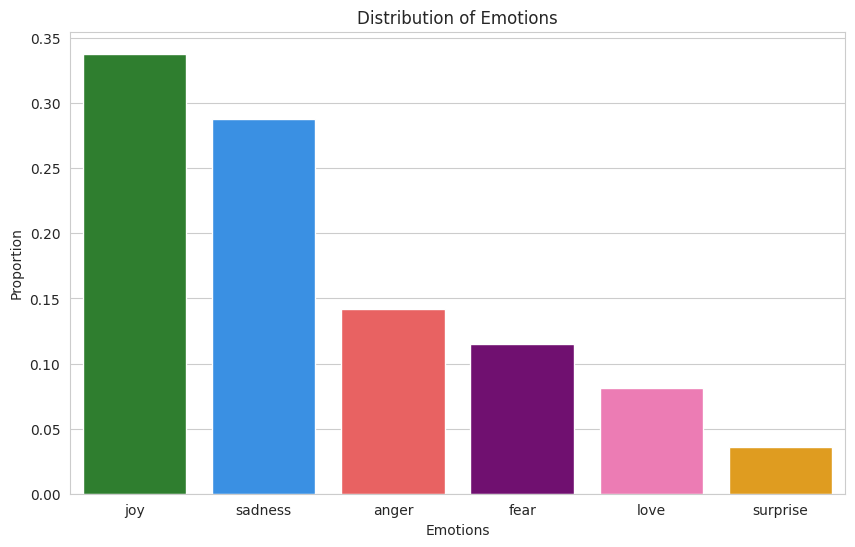

In [89]:
# Compute proportions
distributions=df['emotions'].value_counts(normalize=True)
print(distributions)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.countplot(data=df, x='emotions', order = distributions.index, palette=custom_palette, hue='emotions', legend=False,stat='proportion')
plt.xlabel('Emotions')
plt.ylabel('Proportion')
plt.title('Distribution of Emotions')

We notice that data is unbalanced:
- About 0.65 of samples are joy or sadness
- Surprise is the class with the lowest samples

## Text Analysis
Since dataset is composed of textual data, it is insightful to make some analysis.

First i apply the Preprocessing Pipeline previously defined to extract tokens.
Then i compute some common statistics for **tweet length**
- mean
- standard deviation
- median
- longest and shortest tweets

In [ ]:
# Extract all words
pipeline = PreprocessPipeline()
postprocess_df = df['text'].apply(lambda x : pipeline.clean_text(x))
df['text'] = postprocess_df

all_words = []
all_tweets_length = []
for tweet in df['text']:
  tokens = pipeline.transform(tweet)
  all_words.extend(tokens)
  all_tweets_length.append(len(tokens))

mean_tweets = np.mean(all_tweets_length)
median_tweets = np.median(all_tweets_length)
max_tweet = np.max(all_tweets_length)
min_tweet = np.min(all_tweets_length)
std_tweets = np.std(all_tweets_length)

original_std = std_tweets

In [ ]:
plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
sns.histplot(all_tweets_length, kde=True, color='skyblue', edgecolor='black', alpha=0.7, stat='proportion')
plt.axvline(mean_tweets, color='red', linestyle='--', label=f'Mean: {mean_tweets:.2f}')
plt.axvline(median_tweets, color='green', linestyle='-', label=f'Median: {median_tweets:.2f}')
plt.axvspan(mean_tweets - std_tweets, mean_tweets + std_tweets,
            color='grey', alpha=0.2, label=f'Std Dev: {std_tweets:.2f}')
plt.text(max_tweet, plt.ylim()[1]*0.05, f' Max: {max_tweet}', color='darkred', fontweight='bold')
plt.text(min_tweet, plt.ylim()[1]*0.05, f' Min: {min_tweet}', color='darkblue', fontweight='bold')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Tweets Length Distribution')
plt.legend()

The mean tweet is 19.21 tokens long. The median is at the left of the mean, making the distribution right skeewed because most users write short tweets.

**Padding**: for this task i'm gonna use a tokenizer, choosing a max_len too high is inconvenient if most of the data falls between 0 and 75.

**Outliers**: the distribution has a long tail, but the tweets with >70 lengths have a low frequency, hence may be potential outliers.

Next i'm gonna plot the boxplot of the data.
A box plot shows the distribution of quantitative data in a way that facilitates comparisons between classes (in this case, emotion)

In [ ]:
sns.boxplot(x="emotions",
            y=all_tweets_length,
            data=df,
            palette=custom_palette,
            hue='emotions')
plt.xlabel('Emotions')
plt.ylabel('Tweet Length')
plt.title('Boxplot of Tweet Length by Emotion')

There is no substantial differences for tweet length across different emotions.

For instance, if we consider as outliers greater with a length greater than than 75 tokens, the affected classes would be 'sadness', 'anger' and 'fear'.



## N-Gram Analysis
Analyizing n-gram could help see what words occurs most often for each class.

ONLY for N-Gram anlysis, i'll remove stop words.

In [ ]:

from nltk import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) # I remove stop words
print(stop_words)

Stop words are common english words and contractions. Some of these like "the" don't provide much insight about data but they are very frequent. So i remove them.

## Most Frequent Unigram
In this section i'll compute most frequent unigram that coincide with most frequent words

In [ ]:
# Most Frequent Unigram
# 1. Get unigrams
all_unigrams = [
    word for text in df['text']
    for word in nltk.word_tokenize(str(text).lower())
    if word.isalnum() and word not in stop_words
]

# 2. Count the most common words
counts = Counter(all_unigrams).most_common(10)
words, freq = zip(*counts)

# Setup the Figure BEFORE plotting
sns.set_style("whitegrid")

# 4. Plot
ax = sns.barplot(
    x=list(freq),
    y=list(words),
    hue=list(words),
    palette='viridis',
    legend=False
)

# 5. Styling & Cleanup

plt.title(f'Top 10 Most Frequent: Unigram (Words)', fontsize=14, fontweight='bold')
plt.xlabel('Frequency')
plt.ylabel('')

"feel" and "feeling" are two words that are very frequent in the text. This **probably reflects how data was collected**, by selecting tweets that contains words like "feel" and "feeling".

In this way it's easy to collect tweets that may contains information like "i feel devastated" or "i feel angry" and associated "angry" and "sad" to emotional states.

## Most frequent Bi-grams and Trigrams
Now i'll compute most frequent

In [ ]:
# Process Bigrams
all_bigrams = []

for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 2:
        all_bigrams.extend(list(ngrams(filtered_tokens, 2)))


counts_bi = Counter(all_bigrams).most_common(10)
words_bi = [' '.join(w) for w, f in counts_bi]
freq_bi = [f for w, f in counts_bi]

# Process Trigrams
all_trigrams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    all_trigrams.extend(list(ngrams(tokens, 3)))

counts_tri = Counter(all_trigrams).most_common(10)
words_tri = [' '.join(w) for w, f in counts_tri]
freq_tri = [f for w, f in counts_tri]

# Create a figure with 1 row and 2 columns, wide enough for text
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# --- Left Plot: Bigrams ---
sns.barplot(
    x=freq_bi,
    y=words_bi,
    hue=words_bi,
    palette='viridis',
    legend=False,
    ax=axes[0]  # This places it in the first (left) slot
)
axes[0].set_title('Top 10 Frequent Bigrams', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')

# --- Right Plot: Trigrams ---
sns.barplot(
    x=freq_tri,
    y=words_tri,
    hue=words_tri,
    palette='magma', # Used a different palette to visually distinguish
    legend=False,
    ax=axes[1]  # This places it in the second (right) slot
)
axes[1].set_title('Top 10 Frequent Trigrams', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')

# Adjust layout to prevent overlapping labels
plt.tight_layout()
plt.show()

## Most frequent 4- and 5- Grams

In [ ]:
# --- Process 4-Grams ---
all_4grams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 4:
        all_4grams.extend(list(ngrams(filtered_tokens, 4)))

counts_four = Counter(all_4grams).most_common(10)
words_four = [' '.join(w) for w, f in counts_four]
freq_four = [f for w, f in counts_four]

# --- Process 5-Grams ---
all_5grams = []
for text in df['text']:
    tokens = nltk.word_tokenize(str(text).lower())
    filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words]
    if len(filtered_tokens) >= 5:
        all_5grams.extend(list(ngrams(filtered_tokens, 5)))

counts_five = Counter(all_5grams).most_common(10)
words_five = [' '.join(w) for w, f in counts_five]
freq_five = [f for w, f in counts_five]

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# Left Plot: 4-Grams
sns.barplot(x=freq_four, y=words_four, hue=words_four, palette='viridis', legend=False, ax=axes[0])
axes[0].set_title('Top 10 Frequent 4-Grams', fontsize=14, fontweight='bold')

# Right Plot: 5-Grams
sns.barplot(x=freq_five, y=words_five, hue=words_five, palette='magma', legend=False, ax=axes[1])
axes[1].set_title('Top 10 Frequent 5-Grams', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

Top 10 most frequent 5 and 4-grams were useful to find some noise in the data.

N-Gram comparison between classes.
- Stop words are deleted
- I removed "feel like" because it is a neutral cue

In [ ]:
# Compute subsets
df_sadness = df[df['emotions'] == 'sadness']
df_joy = df[df['emotions'] == 'joy']
df_love = df[df['emotions'] == 'love']
df_anger = df[df['emotions'] == 'anger']
df_fear = df[df['emotions'] == 'fear']
df_surprise = df[df['emotions'] == 'surprise']


stop_words = set(stopwords.words('english'))
print(stop_words)

In [ ]:
cols_to_show = ['text']
display(df_sadness[cols_to_show].head(10))

In [ ]:
def get_filtered_ngrams(dataframe, n, top_n=10):
    all_grams = []
    # Use the same stop words we defined earlier
    stop_words = set(nltk.corpus.stopwords.words('english'))

    banned = {}

    for text in dataframe['text']:
        # 1. Tokenize the CURRENT row
        tokens = nltk.TweetTokenizer().tokenize(str(text).lower())

        # 2. Filter words
        filtered_tokens = [t for t in tokens if t.isalnum() and t not in stop_words and t not in banned]

        # 3. Only create ngrams if we have enough tokens
        if len(filtered_tokens) >= n:
            raw_grams = list(ngrams(filtered_tokens, n))

            all_grams.extend(raw_grams)

    counts = Counter(all_grams).most_common(top_n)

    # If the list is empty, handle it gracefully
    if not counts:
        return [], []

    words = [' '.join(w) for w, f in counts]
    freq = [f for w, f in counts]
    return words, freq

In [ ]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_sad, freq_bi_sad = get_filtered_ngrams(df_sadness, 2)
words_bi_joy, freq_bi_joy = get_filtered_ngrams(df_joy, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(x=freq_bi_sad, y=words_bi_sad, hue=words_bi_sad, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Sadness Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(x=freq_bi_joy, y=words_bi_joy, hue=words_bi_joy, palette='YlOrBr_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 Joy Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_love, freq_bi_love = get_filtered_ngrams(df_love, 2)
words_bi_anger, freq_bi_anger = get_filtered_ngrams(df_anger, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(y=words_bi_love, x=freq_bi_love, hue=freq_bi_love, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Love Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(y=words_bi_anger, x=freq_bi_anger, hue=freq_bi_anger, ax=axes[1], legend=False)
axes[1].set_title('Top 10 Anger Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
# Process Subsets
# We extract Bigrams (n=2) for both labels
words_bi_fear, freq_bi_fear = get_filtered_ngrams(df_fear, 2)
words_bi_surprise, freq_bi_surprise = get_filtered_ngrams(df_surprise, 2)

#  Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.set_style("whitegrid")

# --- Left Plot: Sadness ---
sns.barplot(y=words_bi_fear, x=freq_bi_fear, hue=freq_bi_fear, palette='Blues_r', ax=axes[0], legend=False)
axes[0].set_title('Top 10 Fear Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

# --- Right Plot: Joy ---
sns.barplot(y=words_bi_surprise, x=freq_bi_surprise, hue=freq_bi_surprise, palette='YlOrBr_r', ax=axes[1], legend=False)
axes[1].set_title('Top 10 Surprise Bigrams (No Stop Words)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Data Preprocessing

## Outliers Removal
I will delete only tweets that are on the right side of the distribution, since the distribution is right skeewed. I used standard deviation + mean to make this choice

In [ ]:
# Count tokens for each sample in the dataset
df[:, 'token_count'] = df['text'].apply(lambda x: len(pipeline.transform(str(x))))

In [ ]:
# Remove tweets longer than 6 times the standard deviation + the mean.
outliers_del = int(3*original_std + mean_tweets)
print(f"Outlier delimiter: {outliers_del}")

print(f"Length before filtering: {len(df["text"])}")

filtered_df = df[df['token_count'] <= outliers_del]

print(f"Length after filtering: {len(filtered_df["text"])}")
print(f"Difference (deleted samples): {len(df["text"]) - len(filtered_df["text"])}")

In [ ]:
filtered_df.describe()

In [ ]:
# Plot Tweets length distribution and boxplot after filtering

# Extract all words
all_words = []
all_tweets_length = []
for tweet in filtered_df['text']:
  tokens = pipeline.transform(tweet)
  all_words.extend(tokens)
  all_tweets_length.append(len(tokens))

mean_tweets = np.mean(all_tweets_length)
median_tweets = np.median(all_tweets_length)
std_tweets = np.std(all_tweets_length)

# After filtering the graph look like this

# Create the figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# --- Left Plot: Histogram (Index 0) ---
sns.histplot(all_tweets_length, kde=True, color='skyblue', edgecolor='black', alpha=0.7, ax=axes[0])
axes[0].axvline(mean_tweets, color='red', linestyle='--', label=f'Mean: {mean_tweets:.2f}')
axes[0].axvline(median_tweets, color='green', linestyle='-', label=f'Median: {median_tweets:.2f}')
axes[0].axvspan(mean_tweets - std_tweets, mean_tweets + std_tweets,
                color='grey', alpha=0.2, label=f'Std Dev: {std_tweets:.2f}')
axes[0].set_xlabel('Tweet Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Tweets Length Distribution after filtering', fontsize=14, fontweight='bold')
axes[0].legend()

# --- Right Plot: Boxplot (Index 1) ---
sns.boxplot(x="emotions",
            y=all_tweets_length,
            data=filtered_df,
            palette=custom_palette,
            hue='emotions',
            legend=False,
            ax=axes[1]) # This places it in the second slot
axes[1].set_xlabel('Emotions')
axes[1].set_ylabel('Tweet Length')
axes[1].set_title('Boxplot of Tweet Length by Emotion after filtering', fontsize=14, fontweight='bold')

# Automatically adjust spacing
plt.tight_layout()
plt.show()

In [ ]:
# PLot distribution of emotions after filtering
distributions=filtered_df['emotions'].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.countplot(data=filtered_df, x='emotions', order = distributions.index, palette=custom_palette, hue='emotions', legend=False,stat='proportion')
plt.xlabel('Emotions')
plt.ylabel('Proportion')
plt.title('Distribution of Emotions after filtering')

In [ ]:
df = filtered_df

## Create Dictionary


In [ ]:
# Create dictionary
# Count unique words in the dataset

# count words
word_counts = Counter(all_words)

print(word_counts)

# This allows you to limit vocab size later if needed
most_common_words = sorted(word_counts, key=word_counts.get, reverse=True)

# Define special tokens
# 0 is usually reserved for padding
word2idx = {"<PAD>": 0, "<UNK>": 1}

# Add unique words from your dataframe starting from index 2
for i, word in enumerate(most_common_words):
    word2idx[word] = i + 2

idx2word = {v: k for k, v in word2idx.items()}

print(f"Unique words found: {len(word2idx)}")

def tweet_to_indices(text, word2idx):
    tokens = pipeline.transform(text)
    return [word2idx.get(token, 1) for token in tokens]

del pipeline
pipeline = PreprocessPipeline()

# Clean text
df.loc[:, 'text'] = df['text'].apply(lambda tweet: pipeline.clean_text(tweet))

# Convert to indices
df.loc[:, 'sequences'] = df['text'].apply(lambda tweet: tweet_to_indices(tweet, word2idx))

In [ ]:
pd.set_option('display.max_colwidth', None)
df.head(10)

# Model Architecture

In [ ]:
class EmotionClassifierBaseline(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, glove_weights, distributions=None):
        super(EmotionClassifierBaseline, self).__init__()

        self.distributions = distributions # Prior initialization

        # 1. Embedding Layer
        self.embedding = nn.Embedding.from_pretrained(
            glove_weights,
            freeze=False
        )

        # 2. MLP Layers
        # Since we are averaging embeddings, the input to the first linear layer
        # is just embedding_dim (not hidden_dim * 2)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        # Optional: Add dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, text):
        # text shape: [batch_size, seq_len]

        # 1. Convert tokens to embeddings
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_len, embedding_dim]

        # 2. SIMPLE AVERAGING (The "Baseline" part)
        # We average across the sequence length (dim=1)
        # pooled shape: [batch_size, embedding_dim]
        pooled = torch.mean(embedded, dim=1)

        # 3. Pass through MLP
        x = F.relu(self.fc1(pooled))
        x = self.dropout(x)
        logits = self.fc2(x)

        return logits

    def init_weights(self):
        # Calculate prior biases from distributions
        prior_biases = None
        if self.distributions is not None:
            freqs = torch.tensor(self.distributions, dtype=torch.float)
            # Add epsilon to prevent log(0)
            prior_biases = torch.log(freqs + 1e-9)

        for name, param in self.named_parameters():
            # Skip embedding layer
            if 'embedding' in name:
                continue

            # Xavier for all weights
            if 'weight' in name:
                nn.init.xavier_uniform_(param.data)

            # Bias Initialization
            elif 'bias' in name:
                # Apply prior to the final layer (fc2)
                if name == 'fc2.bias' and prior_biases is not None:
                    param.data.copy_(prior_biases)
                else:
                    param.data.fill_(0)


In [ ]:
class EmotionClassifierLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, glove_weights, distributions=None):
        super(EmotionClassifierLSTM, self).__init__()

        self.distributions = distributions if distributions is not None else torch.ones(6)

        # Define the embedding layer
        self.embedding = nn.Embedding.from_pretrained(
            glove_weights,
            freeze=False  # Set to True if you don't want to fine-tune the embeddings
        )

        # Example Bi-LSTM setup following the embedding
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=1,
            bidirectional=True,
            batch_first=True
        )

        self.attention =  nn.Linear(hidden_dim * 2, 1)

        self.fc = nn.Linear(hidden_dim * 2, output_dim)

        self.init_weights()

    def forward(self, text):
        # text shape: [batch_size, seq_len]

        # 1. Convert tokens to embeddings
        embedded = self.embedding(text)
        # embedded shape: [batch_size, seq_len, embedding_dim]

        # 2. LSTM pass
        lstm_output, (hidden, cell) = self.lstm(embedded)

        # 3. Compute attention
        # pass every hidden state through the attention layer to get a score
        # energy shape [batch_size, seq_len, 1]
        energy = self.attention(lstm_output)
        # Convert scores to weights, shape [batch_size, seq_len, 1]
        weights = F.softmax(energy, dim=1)
        # compute the context vector by linear combination of weights and lsmt output
        context_vector = torch.sum(weights * lstm_output, dim=1)

        # 4. Final Classification
        return self.fc(context_vector)

    def init_weights(self):
        """
        Applies:
          -  Xavier initialization to LSTM and Linear layers
          -  Prior initialization to last layer
        """

        # Calculate biases if distributions are provided
        prior_biases = None
        if distributions is not None:
          freqs = torch.tensor(self.distributions, dtype=torch.float)
          prior_biases = torch.log(freqs + 1e-9)

        for name, param in self.named_parameters():
            # Skip the embedding layer (already loaded from GloVe)
            if 'embedding' in name:
                continue

            # Initialize LSTM weights
            if 'weight_ih' in name or 'weight_hh' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'bias' in name:
                if name== 'fc.bias' and prior_biases is not None: # Prior Initialization
                  param.data.copy_(prior_biases)
                else:
                  param.data.fill_(0) # Initialize LSTM biases to zero

            # Initialize Linear layers (Attention and FC)
            if 'fc.weight' in name or 'attention.weight' in name:
                nn.init.xavier_uniform_(param.data)

# Prepare the dataset for training

In [ ]:
df.head(n=10)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

class EmoDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = [torch.tensor(s) for s in sequences]
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [ ]:
# Divide dataset into train and test

from sklearn.model_selection import train_test_split
# x = your sequences (list of lists of integers)
# y = your labels (0 to 5)
train_sequences, test_sequences, train_labels, test_labels = train_test_split(
    df['sequences'].values,
    df['label_id'].values,
    test_size=0.2,          # 20% for testing
    random_state=42,        # For reproducibility
    stratify=df['label_id'].values
)

In [ ]:
def collate_fn(batch):
    # Sort by length (optional but helps LSTM efficiency)
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    sequences, labels = zip(*batch)

    # Pad sequences to the length of the longest one in this batch
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)

    return padded_sequences, labels

# Create the final DataLoaders
BATCH_SIZE=32

train_loader = DataLoader(
    EmoDataset(train_sequences, train_labels),
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    EmoDataset(test_sequences, test_labels),
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

## Sanity Check: Overfit a sample of data
This serves as a sanity check for the data preprocessing and training loop, ensuring that labels are correctly mapped and gradients are flowing through the attention layer

In [ ]:
# Test: overfit a small sample of the dataset

# 1. Load a small sample of data
small_df = df.sample(1000)
small_train_sequences, small_test_sequences, small_train_labels, small_test_labels = train_test_split(
    small_df['sequences'].values,
    small_df['label_id'].values,
    test_size=0.2,          # 20% for testing
    random_state=42,        # For reproducibility
    stratify=small_df['label_id'].values
)

small_train_loader = DataLoader(
    EmoDataset(small_train_sequences, small_train_labels),
    batch_size=8, shuffle=True, collate_fn=collate_fn
)
small_test_loader = DataLoader(
    EmoDataset(small_test_sequences, small_test_labels), batch_size=8, shuffle=False, collate_fn=collate_fn
)

# Hyperparameters
hyps = {
    "embedding_dim" : 300, # Embedding dimension
    "hidden_dim" : 256, # Hidden dimension
    "output_dim" : 6, # Output dimension
    "lr" : 3e-4, # Learning rate
    "epoch_num" : 100} # Number of training epoch

#  Model Setup
weights = load_glove_embeddings('glove.6B.300d.txt', word2idx, embedding_dim=hyps["embedding_dim"])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_test = EmotionClassifierLSTM(len(word2idx),
                                   hyps["embedding_dim"],
                                   hyps["hidden_dim"],
                                   hyps["output_dim"],
                                   weights)
model_test = model_test.to(device)
criterion_base = nn.CrossEntropyLoss()
optimizer_base = torch.optim.Adam(model_test.parameters(), lr=hyps["lr"])

def train(model, train_loader, device, optimizer, criterion):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for inputs, labels in train_loader:
        # Cast labels to long (int64) which is required by CrossEntropyLoss
        inputs, labels = inputs.to(device), labels.to(device).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_acc = 100 * correct_train / total_train

  return train_loss, train_acc


for epoch in range(hyps["epoch_num"]):
  train_loss, train_acc = train(model_test, small_train_loader, device, optimizer_base, criterion_base)
  if train_acc == 100:
    print("Test done: no errors in the data")
    break
if train_acc < 100:
  print("Test failed: errors in the data")



# Train Baseline Model

In [ ]:
# Define train and validate functions
def train(model, train_loader, device, optimizer, criterion):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for inputs, labels in train_loader:
        # Cast labels to long (int64) which is required by CrossEntropyLoss
        inputs, labels = inputs.to(device), labels.to(device).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_acc = 100 * correct_train / total_train

  return train_loss, train_acc

def validate(model, test_loader, device, criterion):
  model.eval()
  val_loss = 0.0
  correct_val = 0
  total_val = 0

  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          # Cast labels to long for validation as well
          inputs, labels = inputs.to(device), labels.to(device).long()

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          val_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  val_loss = val_loss / len(test_loader)
  val_acc = 100 * correct_val / total_val
  f1_weighted = f1_score(all_labels, all_preds, average='weighted')
  f1_macro = f1_score(all_labels, all_preds, average='macro')
  return val_loss, val_acc, f1_weighted, f1_macro


In [ ]:
# 1. Hyperparameters
hyps = {
    "embedding_dim" : 300, # Embedding dimension
    "hidden_dim" : 256, # Hidden dimension
    "output_dim" : 6, # Output dimension
    "lr" : 3e-4, # Learning rate
    "epoch_num" : 20,
    } # Number of training epoch

# 2. Create obj glove weight matrix and model
weights = load_glove_embeddings('glove.6B.300d.txt', word2idx, embedding_dim=hyps["embedding_dim"])
model_base = EmotionClassifierBaseline(len(word2idx), # Dict
                                       hyps["embedding_dim"],
                                       hyps["hidden_dim"],
                                       hyps["output_dim"],
                                       weights, # Glove Weights
                                       distributions=list(distributions) # Prior Initialization
                                       )

# 3. Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_base = model_base.to(device)

# 4. Loss and Optimizer
# add bias to Cross Entropy Loss
freqs = torch.tensor(list(distributions))
class_weights = 1.0 / freqs
class_weights = class_weights / class_weights.sum() * len(freqs)
criterion_base = nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer_base = torch.optim.Adam(model_base.parameters(), lr=hyps['lr'])

In [ ]:
from sklearn.metrics import f1_score

def train(model, train_loader, device, optimizer, criterion):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for inputs, labels in train_loader:
        # Cast labels to long (int64) which is required by CrossEntropyLoss
        inputs, labels = inputs.to(device), labels.to(device).long()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

  train_loss = running_loss / len(train_loader)
  train_acc = 100 * correct_train / total_train

  return train_loss, train_acc


def top_k_accuracy(output, target, k=2):
  """
  Computes the accuracy over the k top predictions
  """
  with torch.no_grad():
      batch_size = target.size(0)

      # Get the indices of the top k predictions
      # _, pred shape: [batch_size, k]
      _, pred = output.topk(k, 1, True, True)

      # Transpose to [k, batch_size] to compare with target
      pred = pred.t()

      # Compare pred with target (target is broadcasted)
      # correct shape: [k, batch_size] (Boolean)
      correct = pred.eq(target.view(1, -1).expand_as(pred))

      # Sum the correct predictions
      correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
      return correct_k.item()


def validate(model, test_loader, device, criterion):
  model.eval()

  val_loss = 0.0 # Validation Loss
  correct_val = 0 # Accuracy counter
  correct_topk = 0 # Top-k Accuracy counter
  total_val = 0 # Total validation loss

  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          # Cast labels to long for validation as well
          inputs, labels = inputs.to(device), labels.to(device).long()

          # Get output
          outputs = model(inputs)

          # Standard Validation Loss
          loss = criterion(outputs, labels)
          val_loss += loss.item()

          # Standard Accuracy (Top-1)
          _, predicted = torch.max(outputs.data, 1)
          total_val += labels.size(0)
          correct_val += (predicted == labels).sum().item()

          # Top-2 accuracy
          correct_topk += top_k_accuracy(outputs, labels, k=2)

          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  val_loss = val_loss / len(test_loader)
  val_acc = 100 * correct_val / total_val
  topk_acc = 100 * correct_topk / total_val
  f1_weighted = f1_score(all_labels, all_preds, average='weighted')
  f1_macro = f1_score(all_labels, all_preds, average='macro')

  return val_loss, val_acc, f1_weighted, f1_macro, topk_acc



In [ ]:
# Save F1-Score history, both weighted and macro
history_base = {'weighted': [], 'macro': [], 'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 5

# Train loop
try:
  for epoch in range(hyps["epoch_num"]):
    # Calls train and validate custom functions
    train_loss, train_acc = train(model_base, train_loader, device, optimizer_base, criterion_base)
    val_loss, val_acc, f1_weighted, f1_macro, topk_acc = validate(model_base, test_loader, device, criterion_base)

    # Print metrics
    print(f'Epoch [{epoch+1}/{hyps["epoch_num"]}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%,  '
          f"Top-2 Val Accuracy: {topk_acc:.2f}%, "
          f'Weighted F1-Score: {f1_weighted:.4f},  '
          f'Macro F1-Score: {f1_macro:.4f},  ')

    # Add results to history dictionary
    history_base['weighted'].append(f1_weighted)
    history_base['macro'].append(f1_macro)
    history_base['train_loss'].append(train_loss)
    history_base['val_loss'].append(val_loss)


    # Early stopping
    patience_counter += 1
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        file_path_base = f"./best_model_baseline_v1_f1_{f1_weighted:.4f}.pt"
        torch.save({
          'epoch': epoch + 1,
          'model_state_dict': model_base.state_dict(),
          'optimizer_state_dict': optimizer_base.state_dict(),
          'loss': best_val_loss,
          'history': history_base
          }, file_path_base)

    if patience_counter == patience_limit:
      print(f"Early stopping, model didn't improved for {patience_limit} epochs")
      break

except KeyboardInterrupt:
  print("\n" + "-"*30)
  print("Training manually interrupted")


# Train LSTM with attention

In [ ]:
if model_lstm:
  del model_lstm
if optimizer_lstm:
  del optimizer_lstm
if criterion_lstm:
  del criterion_lstm

In [ ]:
# 1. Hyperparameters
hyps = {
    "embedding_dim" : 300, # Embedding dimension
    "hidden_dim" : 128, # Hidden dimension
    "output_dim" : 6, # Output dimension
    "lr" : 5e-4, # Learning rate
    "wd" : 1e-5, #Weight Decay
    "epoch_num" : 20} # Number of training epoch

# 2. Create obj glove weight matrix and model
weights = load_glove_embeddings('glove.6B.300d.txt', word2idx, embedding_dim=hyps["embedding_dim"])
model_lstm = EmotionClassifierLSTM(len(word2idx), # Vocab Size
                                   hyps["embedding_dim"],
                                   hyps["hidden_dim"],
                                   hyps["output_dim"],
                                   weights, # Glove Weights
                                   distributions=list(distributions)) # Prior Initialization


# 3. Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lstm = model_lstm.to(device)

# 4. Loss and Optimizer
# Add bias to CrossEntropyLoss
freqs = torch.tensor(list(distributions))
class_weights = 1.0 / freqs
class_weights = class_weights / class_weights.sum() * len(freqs)
criterion_lstm = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_lstm = torch.optim.Adam(model_lstm.parameters(), lr=hyps['lr'], weight_decay=hyps["wd"])


In [ ]:
# Save F1-Score history, both weighted and macro
history_lstm = {'weighted': [], 'macro': [], 'train_loss' : [], 'val_loss': []}
best_val_loss = float('inf')
patience_counter = 0
patience_limit = 5

# Train loop, calls train and validate custom functions
try:
  for epoch in range(hyps["epoch_num"]):
    # Calls train and validate custom functions
    train_loss, train_acc = train(model_lstm, train_loader, device, optimizer_lstm, criterion_lstm)
    val_loss, val_acc, f1_weighted, f1_macro, topk_acc = validate(model_lstm, test_loader, device, criterion_lstm)

    # Print metrics
    print(f'Epoch [{epoch+1}/{hyps["epoch_num"]}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%,  '
          f"Top-2 Val Accuracy: {topk_acc:.2f}%, "
          f'Weighted F1-Score: {f1_weighted:.4f},  '
          f'Macro F1-Score: {f1_macro:.4f},  ')

    # Add results to history dictionary
    history_lstm['weighted'].append(f1_weighted)
    history_lstm['macro'].append(f1_macro)
    history_lstm['train_loss'].append(train_loss)
    history_lstm['val_loss'].append(val_loss)


    # Early stopping
    patience_counter += 1
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        file_path = f"./best_model_lstm_attn_v1_f1_{f1_weighted:.4f}.pt"
        torch.save({
          'epoch': epoch + 1,
          'model_state_dict': model_lstm.state_dict(),
          'optimizer_state_dict': optimizer_lstm.state_dict(),
          'loss': best_val_loss,
          'history' : history_lstm
          }, file_path)

    if patience_counter == patience_limit:
      print(f"\nEarly stopping, model didn't improved for {patience_limit} epochs")
      break


except KeyboardInterrupt:
  print("\n" + "-"*30)
  print("Training manually interrupted")
  print("-"*30)


# Evaluation and Metrics

## Evaluating Baseline Model

In [ ]:
# Visualize F1 weighted and F1 Macro history with Seaborn

# 1. Load the best model
model_name = "./best_model_baseline_v1_f1_0.8999.pt"
loaded = torch.load(model_name)
last_epoch = loaded['epoch']
model_base.load_state_dict(loaded['model_state_dict'])
history_base = loaded['history']

# 2. Prepare data for F1 Score
epochs = range(1, last_epoch + 1)
df_f1 = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs),
    'Score': history_base['weighted'] + history_base['macro'],
    'Metric Type': ['Weighted F1'] * len(epochs) + ['Macro F1'] * len(epochs)
})

# 3. Prepare Data for Loss
df_loss = pd.DataFrame({
    'Epoch': list(epochs) * 2,
    'Loss': history_base['train_loss'] + history_base['val_loss'],
    'Loss Type': ['Train Loss'] * len(epochs) + ['Val Loss'] * len(epochs)
})

# 4. Create side by side plot plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# Left Plot: F1 Scores
sns.lineplot(data=df_f1, x='Epoch', y='Score', hue='Metric Type',
             marker='o', linewidth=2.5, ax=axes[0])
axes[0].set_title('F1 Score Evolution', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel('Score')

# Right Plot: Training & Validation Loss
sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Loss Type',
             marker='s', linewidth=2.5, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Loss Evolution (Train vs Val)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cross Entropy Loss')

# 4. Plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(all_labels, all_preds, emotions_list):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))

    # Use fmt='d' for integers, cmap='Blues' for clarity
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions_list,
                yticklabels=emotions_list)

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix: Emotion Classification', fontsize=15)
    plt.show()

# Use it after your final validation call
all_labels = df['label_id']

model_base.eval()

def get_all_preds(data_row, model):
    predicted_idx=0
    model.eval()
    sequences = data_row['sequences']
    input_tensor = torch.tensor(sequences).unsqueeze(0).to(device)

    with torch.no_grad():
      output = model(input_tensor)
      predicted_idx = torch.argmax(output, dim=1).item()
    return predicted_idx

all_preds= df.apply(lambda row: get_all_preds(row, model_base), axis=1)

target_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_cm(all_labels, all_preds, target_labels)

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=target_labels))

In [ ]:
# Matthews Correlation Coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mc = matthews_corrcoef(all_labels, all_preds)
print(mc) # ranges between -1 and +1, if closer to +1 it is closer to perfect prediction

## Evaluating LSTM with Attention

In [ ]:
# Visualize F1 weighted and F1 Macro history with Seaborn

# 1. Load the best model
model_name = "./best_model_lstm_attn_v1_f1_0.9392.pt"
loaded = torch.load(model_name)
last_epoch = loaded['epoch']
model_lstm.load_state_dict(loaded['model_state_dict'])
history_lstm = loaded['history'] if 'history' in loaded else None


# 1. Prepare data for F1
max_range = max(last_epoch+1, len(history_lstm['weighted']))
epochs = range(1, max_range)
df_metrics_base = pd.DataFrame({
    'Epoch': list(epochs) + list(epochs),
    'Score': history_lstm['weighted'] + history_lstm['macro'],
    'Metric Type': ['Weighted F1'] * len(epochs) + ['Macro F1'] * len(epochs)
})

# 2. Prepare Data for Loss
df_loss = pd.DataFrame({
    'Epoch': list(epochs) * 2,
    'Loss': history_lstm['train_loss'] + history_lstm['val_loss'],
    'Loss Type': ['Train Loss'] * len(epochs) + ['Val Loss'] * len(epochs)
})

# 3. Create side by side plot plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.set_style("whitegrid")

# Left Plot: F1 Scores
sns.lineplot(data=df_f1, x='Epoch', y='Score', hue='Metric Type',
             marker='o', linewidth=2.5, ax=axes[0])
axes[0].set_title('F1 Score Evolution', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.05)
axes[0].set_ylabel('Score')

# Right Plot: Training & Validation Loss
sns.lineplot(data=df_loss, x='Epoch', y='Loss', hue='Loss Type',
             marker='s', linewidth=2.5, ax=axes[1], palette=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Loss Evolution (Train vs Val)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Cross Entropy Loss')

# 4. Plot
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_cm(all_labels, all_preds, emotions_list):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))

    # Use fmt='d' for integers, cmap='Blues' for clarity
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotions_list,
                yticklabels=emotions_list)

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix: Emotion Classification', fontsize=15)
    plt.show()

# Use it after your final validation call
all_labels = df['label_id']

model_base.eval()

def get_all_preds(data_row, model):
    predicted_idx=0
    model.eval()
    sequences = data_row['sequences']
    input_tensor = torch.tensor(sequences).unsqueeze(0).to(device)

    with torch.no_grad():
      output = model(input_tensor)
      predicted_idx = torch.argmax(output, dim=1).item()
    return predicted_idx

all_preds= df.apply(lambda row: get_all_preds(row, model_lstm), axis=1)

target_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
plot_cm(all_labels, all_preds, target_labels)

In [ ]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=target_labels))

In [ ]:
# Matthews Correlation Coefficient (MCC)
from sklearn.metrics import matthews_corrcoef
mc = matthews_corrcoef(all_labels, all_preds)
print(mc) # ranges between -1 and +1, if closer to +1 it is closer to perfect prediction

# Inference Testing

In [ ]:
# Test inference for base model
model_base.eval()

# Select a random tweet from the dataset
random_row = df.sample(1).iloc[0]
tweet = random_row['text']
true_label = random_row['emotions']

# Preprocess the tweet
indices = tweet_to_indices(tweet, word2idx)

# Convert to tensor and add batch dimension (batch_size=1)
input_tensor = torch.tensor(indices).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model_base(input_tensor)
    predicted_idx = torch.argmax(output, dim=1).item()
    # Use emotion_to_id which maps int -> string (variable names were swapped in definition)
    predicted_label = emotion_to_id[predicted_idx]

# Display results
print(f"Tweet: {tweet}")
print(f"True Emotion: {true_label}")
print(f"Predicted Emotion: {predicted_label}")

In [ ]:
# Test inference for lstm model
model_lstm.eval()

# Select a random tweet from the dataset
random_row = df.sample(1).iloc[0]
tweet = random_row['text']
true_label = random_row['emotions']

# Preprocess the tweet
indices = tweet_to_indices(tweet, word2idx)

# Convert to tensor and add batch dimension (batch_size=1)
input_tensor = torch.tensor(indices).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model_base(input_tensor)
    predicted_idx = torch.argmax(output, dim=1).item()
    # Use emotion_to_id which maps int -> string (variable names were swapped in definition)
    predicted_label = emotion_to_id[predicted_idx]

# Display results
print(f"Tweet: {tweet}")
print(f"True Emotion: {true_label}")
print(f"Predicted Emotion: {predicted_label}")